<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1lexemes_subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
1. group by delta, history fraction for every student, see if you can see who are the top performers, bottom performers. Is there a way to cluster them?

after trying in prev notebook, we now add session seen, and replace history correct with history fraction correct. 

In [2]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [3]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [4]:
datadfq1.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
7,1.0,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
15,1.0,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
20,1.0,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,"(u:dDwF, c84476c460737d9fb905dca3d35ec995)","(u:dDwF, en)"
21,1.0,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,"(u:dDwF, 1a913f2ded424985b9c02d0436008511)","(u:dDwF, en)"
22,1.0,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,"(u:dDwF, 38b770e66595fea718366523b4f7db3f)","(u:dDwF, en)"


For now, without looking at individual time traces of student-word, we will just look at student id, delta, history fraction, and see if we can predict if they forgot the word. (the difficulty of the word being captured in history fraction)

In [36]:
datadfq1['user_id'].value_counts().sort_values(ascending=False).head(3)

u:bcH_    12629
u:IY_      5528
u:hDLF     5147
Name: user_id, dtype: int64

We can use u:bcH_ as an example to train on. 

In [37]:
q1lexemes = decompress_pickle(path_name+"q1_lexeme_features.pbz2")

In [38]:
user1 = datadfq1.sample(frac = 0.005)
user1.shape[0]

36567

In [39]:
user1.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
5443174,1.0,1362515220,894,u:hV3_,it,en,60ca04f13f84bd807301e4407f7b6f18,loro/lui<prn><tn><p3><mf><pl>,38,33,2,2,"(u:hV3_, 60ca04f13f84bd807301e4407f7b6f18)","(u:hV3_, en)"
8182373,1.0,1362709519,4881311,u:gbmG,en,pt,ca886bc339ea78c58abea6250665ad49,orange/orange<n><sg>,13,9,1,1,"(u:gbmG, ca886bc339ea78c58abea6250665ad49)","(u:gbmG, pt)"
9272344,1.0,1362800928,151,u:iM2C,fr,en,af9481e863fdda9560e1d5020b9cd9a0,bol/bol<n><m><sg>,5,5,3,3,"(u:iM2C, af9481e863fdda9560e1d5020b9cd9a0)","(u:iM2C, en)"
3443791,1.0,1362356098,153802,u:iu7q,fr,en,7d5c9c888f97a47883c8c0065efd1cde,oui/oui<adv>,3,2,3,3,"(u:iu7q, 7d5c9c888f97a47883c8c0065efd1cde)","(u:iu7q, en)"
6121377,1.0,1362567928,255,u:h2wS,it,en,3ac396fd4e13c7952bafa99fcfd02d29,mela/mela<n><f><sg>,26,24,2,2,"(u:h2wS, 3ac396fd4e13c7952bafa99fcfd02d29)","(u:h2wS, en)"


In [40]:
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen','lexeme_id','timestamp']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot'],axis=1)

q1lexemes_sub = q1lexemes#q1lexemes[['lexeme_id','learning_language','sf_length','pos']+[col for col in q1lexemes.columns if (q1lexemes[col].dtype!='object')]]
user1_1 = pd.merge(left = user1, right = q1lexemes_sub,left_on = 'lexeme_id',right_on = 'lexeme_id',how='left')
user1_1 = user1_1.drop(['p_recall','lexeme_id','timestamp'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [41]:
user1_1['partofspeech'] = [user1_1['pos'].loc[i][0] for i in range(user1_1['pos'].shape[0])]
posdummies = pd.get_dummies(user1_1['partofspeech'],drop_first=True,prefix='POS')
lldummies = pd.get_dummies(user1_1['learning_language'],drop_first=True, prefix= 'LL')
uildummies = pd.get_dummies(user1_1['learning_language'],drop_first=True, prefix= 'UIL')
user1_1 = pd.concat([user1_1,posdummies,lldummies,uildummies],axis=1)
user1_1 = user1_1.drop(['partofspeech','pos','index'],axis=1)
user1_1.head()



,delta,history_frac,history_seen,session_seen,p_forgot_bin,learning_language,lexeme_string,surface_form,lemma_form,modstrings,...,POS_vbmod,POS_vbser,LL_es,LL_fr,LL_it,LL_pt,UIL_es,UIL_fr,UIL_it,UIL_pt
0,894,0.868421,38,2,0,it,loro/lui<prn><tn><p3><mf><pl>,loro,lui,"[tn, p3, mf, pl]",...,0,0,0,0,1,0,0,0,1,0
1,4881311,0.692308,13,1,0,en,orange/orange<n><sg>,orange,orange,[sg],...,0,0,0,0,0,0,0,0,0,0
2,151,1.000000,5,3,0,fr,bol/bol<n><m><sg>,bol,bol,"[m, sg]",...,0,0,0,1,0,0,0,1,0,0
3,153802,0.666667,3,3,0,fr,oui/oui<adv>,oui,oui,[],...,0,0,0,1,0,0,0,1,0,0
4,255,0.923077,26,2,0,it,mela/mela<n><f><sg>,mela,mela,"[f, sg]",...,0,0,0,0,1,0,0,0,1,0


In [42]:
user1_1 = user1_1.select_dtypes(exclude='object')

In [43]:
from sklearn.model_selection import train_test_split

X = user1_1.drop('p_forgot_bin',axis=1)
y = user1_1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.1,stratify=y)

In [44]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 5,subsample = 0.5)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.8408690367669401
XG Boost test set score: 0.8364779874213837


In [48]:
y_train.value_counts(normalize=True)

0    0.838074
1    0.161926
Name: p_forgot_bin, dtype: float64

In [49]:
y_probaXGB = XGB_model.predict_proba(X_mm_test)[:,1]

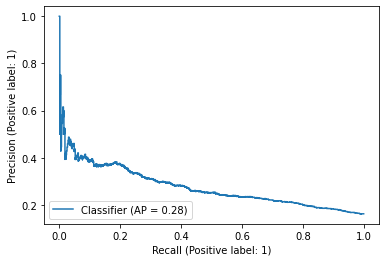

In [50]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB)

In [51]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier(n_estimators=150, learning_rate=1)

AB_model.fit(X_train_unscaled,y_train)
y_probaAB = AB_model.predict_proba(X_test_unscaled)[:,1]

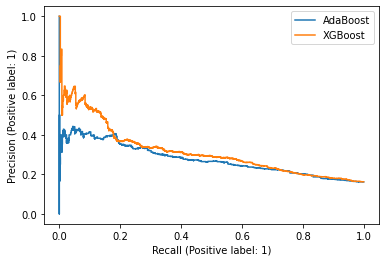

In [33]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
plt.figure()
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test,y_probaAB,ax=ax,label="AdaBoost")
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB,ax=ax,label="XGBoost")
plt.legend()
plt.show()

In [52]:
pd.Series(dict(zip(X_test_unscaled.columns,AB_model.feature_importances_))).sort_values(ascending=False).head(10)

delta           0.046667
session_seen    0.046667
history_frac    0.040000
history_seen    0.020000
dos             0.013333
fa              0.006667
form            0.006667
ff              0.006667
fes             0.006667
fami            0.006667
dtype: float64

Take a subset of 20,000, and use all features. expect around baseline accuracy. 